# Project 1 (Part A)
In this section we investigate the efficacy of various neural network architectures applied to the Parkinson's classification dataset available on the UCI Machine Learning Repository.

## Exploratory Data Analysis
We begin by importing the data and generating some summary visuals.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn import preprocessing

from matplotlib.gridspec import GridSpec

In [2]:
raw_data = pd.read_csv('../data/parkinsons/train_data.txt', header=None)
raw_data = raw_data.drop([0, 27], axis=1)
raw_data[[20]] = raw_data[[20]].astype('float64')
raw_data[[21]] = raw_data[[21]].astype('float64')
raw_data[[25]] = raw_data[[25]].astype('float64')
raw_data[[28]] = raw_data[[28]].astype('int64')

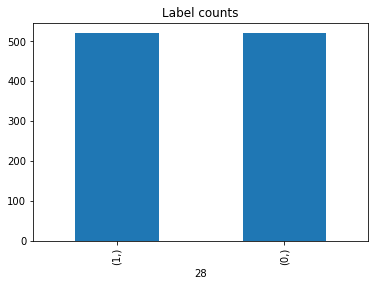

In [3]:
raw_data[[28]].value_counts().plot(kind='bar', title='Label counts')
plt.show()

Fortunately the dataset is balanced, in that we have an equal number of examples of each class. This will facilitate training later on. What about the distribution of our 26 input variables?

In [4]:
X = raw_data.loc[:,:26].values
y = raw_data[[28]].values.ravel()

In [5]:
X_scaled = preprocessing.scale(X)

In [6]:
tsne = TSNE()
X_reduced = tsne.fit_transform(X_scaled)

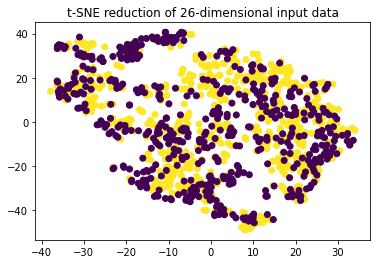

In [7]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
plt.title('t-SNE reduction of 26-dimensional input data')
plt.show()

Using $t$-SNE, a dimensionality-reduction algorithm, we are able to visualise the 26 inputs dimensions in a scatter plot. Unfortunately it appears that many examples of different classes are clustered together, which suggests that training an accurate classifier may be difficult.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X_scaled, y, test_size=0.20, random_state=42)

## Experimenting with a simple classifier
Before building a neural network, we first experiment with two traditional classifiers to establish a baseline level of performance.

In [9]:
model = LogisticRegression()

model.fit(X_train,y_train)
model.score(X_test,y_test)

0.6875

So with an $\ell_2$-regularised logistic regression classifier, we have obtained a baseline accuracy of $69\%$ on the test set.

In [10]:
model = SVC()

model.fit(X_train,y_train)
model.score(X_test,y_test)

0.7259615384615384

Meanwhile with an out-of-the-box support vector machine, we have obtained a baseline accurace of $73\%$ on the test set. This will be our figure to beat. 

## Building a neural network
We now proceed to building a baseline neural network, which will later be improved upon.

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(26,128)
        self.fc2 = nn.Linear(128,2)
        
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        
        return x

In [12]:
model = Net()

## Training a neural network
We are now ready to train our neural network.

In [13]:
train_dataset = TensorDataset(
    torch.from_numpy(X_train).type(torch.float),
    torch.from_numpy(y_train)
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(
    torch.from_numpy(X_test).type(torch.float),
    torch.from_numpy(y_test)
)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [65]:
model = Net()

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)

In [67]:
n_epochs = 300

train_losses = []
test_losses = []
test_accuracies = []

for e in range(n_epochs):
    
    model.train()
    for ii, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad() 

        logits = model(inputs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item() / inputs.shape[0])
    
    
    test_loss = 0
    accuracy = 0
    
    model.eval()
    for ii, (inputs, labels) in enumerate(test_dataloader):
        with torch.no_grad():
            logits = model(inputs)
            loss = criterion(logits, labels)

            test_loss += loss.item() / inputs.shape[0]

            preds = logits.argmax(dim=1)
            
            correct = (preds == labels).type(torch.FloatTensor)
            accuracy += torch.mean(correct).item()
        
    test_losses.append(test_loss)
    test_accuracies.append(accuracy / len(test_dataloader))

In [68]:
window_length = 25
train_losses_averaged = np.convolve(np.array(train_losses), 
                                    np.ones((window_length,)) / window_length, 
                                    mode='valid')

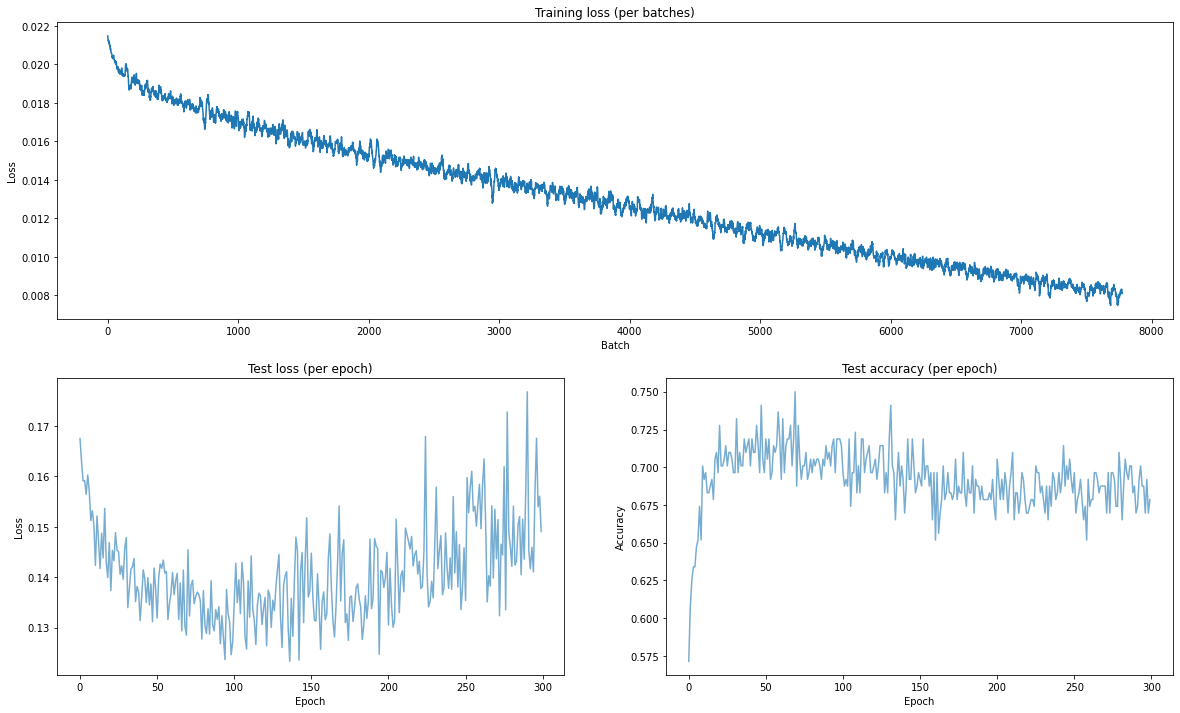

In [69]:
fig = plt.figure(figsize=(20,12))
gs = GridSpec(2, 2, figure=fig)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

ax1.plot(train_losses_averaged)
ax2.plot(test_losses, alpha=0.6)
ax3.plot(test_accuracies, alpha=0.6)

ax1.set_title('Training loss (per batches)')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')

ax2.set_title('Test loss (per epoch)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.set_title('Test accuracy (per epoch)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')

plt.show()

Already we see all the classical hallmarks of the training process: monotonic training loss and parabolic test curves, together clearly demonstrating overtraining.

## Experimentation
Now we consider a number of experiments. Before doing so, we first wrap some of the above code into functions.

In [86]:
def train_network(train_dataloader, test_dataloader, 
                  network, optimizer, criterion, n_epochs, 
                  experiment_name, window_length=40):
    
    train_losses = []
    test_losses = []
    test_accuracies = []

    for e in range(n_epochs):

        model.train()
        for ii, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad() 

            logits = model(inputs)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item() / inputs.shape[0])


        test_loss = 0
        accuracy = 0

        model.eval()
        for ii, (inputs, labels) in enumerate(test_dataloader):
            with torch.no_grad():
                logits = model(inputs)
                loss = criterion(logits, labels)

                test_loss += loss.item() / inputs.shape[0]

                preds = logits.argmax(dim=1)

                correct = (preds == labels).type(torch.FloatTensor)
                accuracy += torch.mean(correct).item()

        test_losses.append(test_loss)
        test_accuracies.append(accuracy / len(test_dataloader))
        
    train_losses_averaged = np.convolve(np.array(train_losses), 
                                        np.ones((window_length,)) / window_length, 
                                        mode='valid')
        
    results = {'train_losses': train_losses,
               'train_losses_averaged': train_losses_averaged,
               'test_losses': test_losses, 
               'test_accuracies': test_accuracies, 
               'experiment_name': experiment_name}
    return results

def plot_results(experiment_results, window_length=40):
    
    fig = plt.figure(figsize=(20,12))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    
    for experiment in experiment_results:
        ax1.plot(experiment['train_losses_averaged'],
                 label=experiment['experiment_name'])
        ax2.plot(experiment['test_losses'], alpha=0.6)
        ax3.plot(experiment['test_accuracies'], alpha=0.6)

    ax1.set_title('Training loss (mean per {} batches)'.format(str(window_length)))
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    ax2.set_title('Test loss (per epoch)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')

    ax3.set_title('Test accuracy (per epoch)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')

### 1. Optimisers
Let us first consider the effects of two different optimisers: Adam and SGD. To make the latter more interesting, we add some momentum.

In [87]:
results_adam = train_network(train_dataloader, test_dataloader, Net(), 
                             optim.Adam(model.parameters(), lr=0.03), nn.CrossEntropyLoss(), 300, 
                             'Adam')
results_SGD = train_network(train_dataloader, test_dataloader, Net(), 
                            optim.SGD(model.parameters(), lr=0.03, momentum=0.1), nn.CrossEntropyLoss(), 300, 
                            'SGD')

experiment_results = [results_adam, results_SGD]

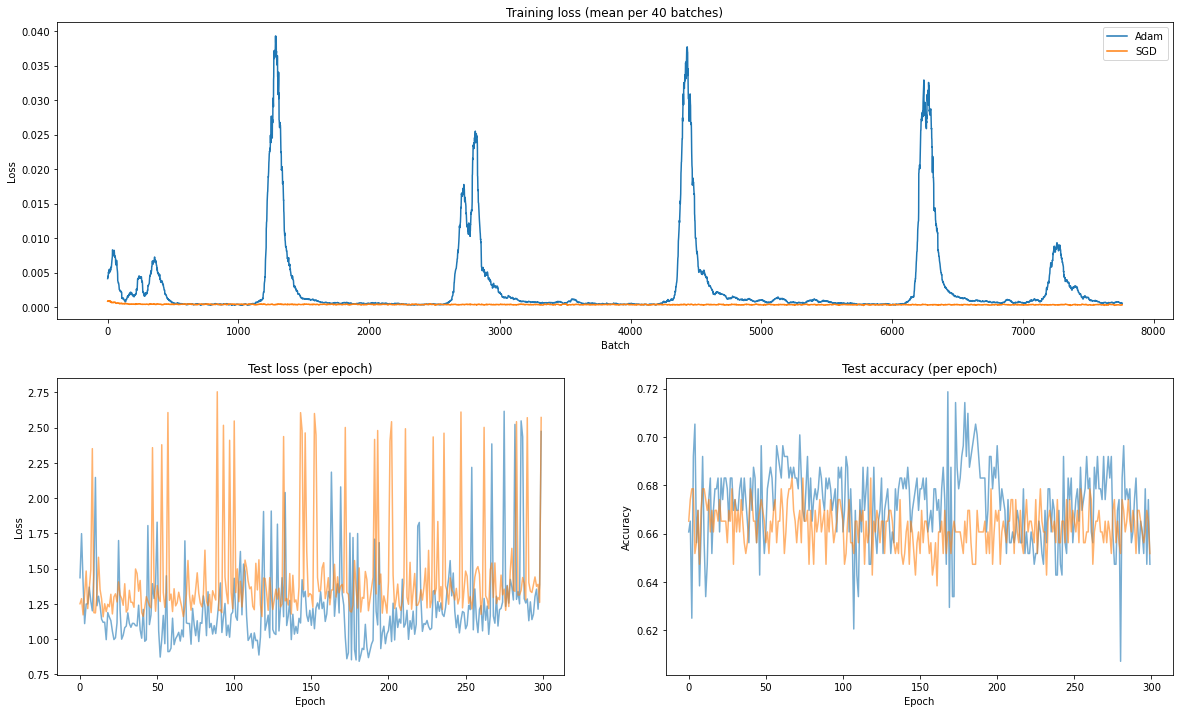

In [88]:
plot_results(experiment_results)

### 2. Learning Rate and Momentum
Since SGD has had more consistent success, we experiment with the learning rate and momentum applied to it.

In [96]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
experiment_results = []

for learning_rate in learning_rates:
    experiment_results.append(train_network(train_dataloader, test_dataloader, Net(), 
                            optim.SGD(model.parameters(), lr=learning_rate), nn.CrossEntropyLoss(), 300, 
                            'lr: {}'.format(str(learning_rate)), window_length=5000))

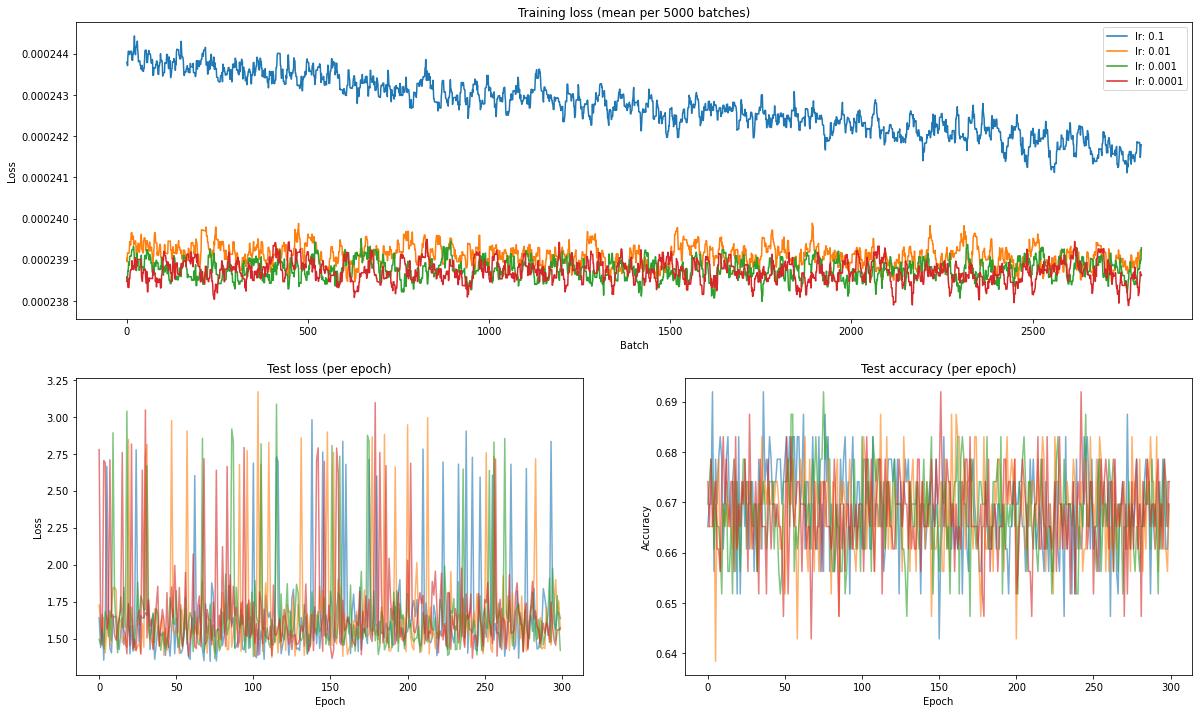

In [97]:
plot_results(experiment_results, window_length=5000)

### 3. Network Depth
Next we experiment with the actual structure of the network which is being trained. In particular, we will try adding layers to the network.